In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def getNumber(data, digit):
    # wähle alle Zeilen in denen die erste Spalte (Spalte mit den Ziffer) mit 'digit' übereinstimmt
    data_number = pd.DataFrame(data[data[0] == digit]) 
    # schneide die erste Spalte weg und gebe den rest zurück
    separated_data = data_number.iloc[:,1:]
    return separated_data

def getNumberImage(data, digit, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, digit)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

In [3]:
class Experiment:
    def __init__(self, targets_train, targets_predict):
        self.results_train = pd.DataFrame(targets_train, columns=["targets"])
        self.results_predict = pd.DataFrame(targets_predict, columns = ["targets"])
        self.input_data = {}
        
        self.names = []        
        self.configs = []

        
    def get_names(self):
        return self.names
    
    
    def get_results(self, train = False):
        if train:
            return self.results_train
        else:
            return self.results_predict
    
    def get_config_map(self):
        for conf in self.configs:
            print("CONFIG:", conf['name'], conf['input_data_name'], "\tNum features:", self.input_data[conf['input_data_name']]['data'].shape[1])
    
    
    def add_input_data(self, name, data, description=""):
        self.input_data[name] = {'description': description, 'data': data}
    
    
    def add_config(self, algo, name, input_data_name):
        # TODO: add check for dublicate names
        if input_data_name not in self.input_data:
            print("ERROR: feature_set_name not found")
            return 
        
        self.names.append(name)
        self.configs.append({ 'name': name, 'algo': algo, 'input_data_name': input_data_name, 'fit': -1})
        

    def _fit(self, conf):
        # get features
        input_data = self.input_data[conf['input_data_name']]['data']

        # fit the features
        print("Fitting ", conf['name'], "... ",)
        
        start = time.time() # startzeit
        conf['fit'] = conf['algo'].fit(input_data, self.results_train['targets'])
        end = time.time() # startzeit
        
        print("done in ", end - start , "s.")

        
    def _predict(self, conf, data, train):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print("ERROR: Number of input features does not match (", conf['name'], ")")
            return
        
        print("Predicting data with", conf['name'], "... ",)
        
        start = time.time() # startzeit
        if train:
            self.results_train[conf['name']] = conf['algo'].predict(data)
        else:
            self.results_predict[conf['name']] = conf['algo'].predict(data)
                                                                    
        end = time.time() # startzeit
        
        print("done in ", end - start , "s.")

        
    def fit(self):
        '''Only trains algorithms if no fit has been calculated before'''
        for conf in self.configs:
            if conf['fit'] == -1:
                self._fit(conf)

                
    def fit_all(self, data):
        '''Trains all algorithms with given data'''
        for conf in self.configs:
            self._fit(conf)

            
    def refit(self, data):
        '''Retrains all algorithms with given data that have been trained before'''
        for conf in self.configs:
            if conf['fit'] != -1:
                self._fit(conf)

                
    def predict(self, name, data, train = False):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                self._predict(conf, data, train)

    def predict_all(self, data, train = False):
        for conf in self.configs:
            if conf['fit'] != -1:
                self._predict(conf, data, train)

                
    def get_count_df(self, name):
        count_matrix = np.zeros((10,10)) 
        for digit in range(0,10):
            cluster_counts = self.results_train[self.results_train['targets'] == digit].groupby(name).count()['targets']
            for cluster in cluster_counts.keys():
                count_matrix[digit][cluster] = cluster_counts[cluster]
        
        col_names = []
        for i in range(0,10):
            col_names.append("C_" + str(i))
    
        return pd.DataFrame(count_matrix, columns=col_names)

    def get_norm_df(self, name):
        count_df = self.get_count_df(name)
        return count_df.divide(count_df.sum(1), axis=0)
    
    
    def get_all_error_rates(self):
        error_rates = {}
        for conf in self.configs:
            if (conf['fit'] != -1) & (conf['name'] in self.results_train.columns):
                error_rates[conf['name']] = self.get_error_rate(conf['name'])
        return error_rates
                
    def get_error_rate(self, name):
        '''Determine classification error by identifying best fitting column assignment'''

In [4]:
# mit header=None, wird die erste Zeile der Datei nicht als Header interpretiert 
#              (Man könnte den Header in einem solchen Fall als Zeile mit den Spaltenüberschriften bezeichnen)
# mit sep=" ", geben wir an, dass wir das Leerzeichen als Seperator verwenden wollen. 
#              D.h. zwei durch ein Leerzeichen separierte Werte sollen als zwei Werte eingelesen werden.
data_train = pd.read_csv("Daten/zip.train", header=None, sep=" ") 

In [5]:
cleaned_train_data = data_train.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_train_data.shape

(7291, 257)

In [6]:
cleaned_train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


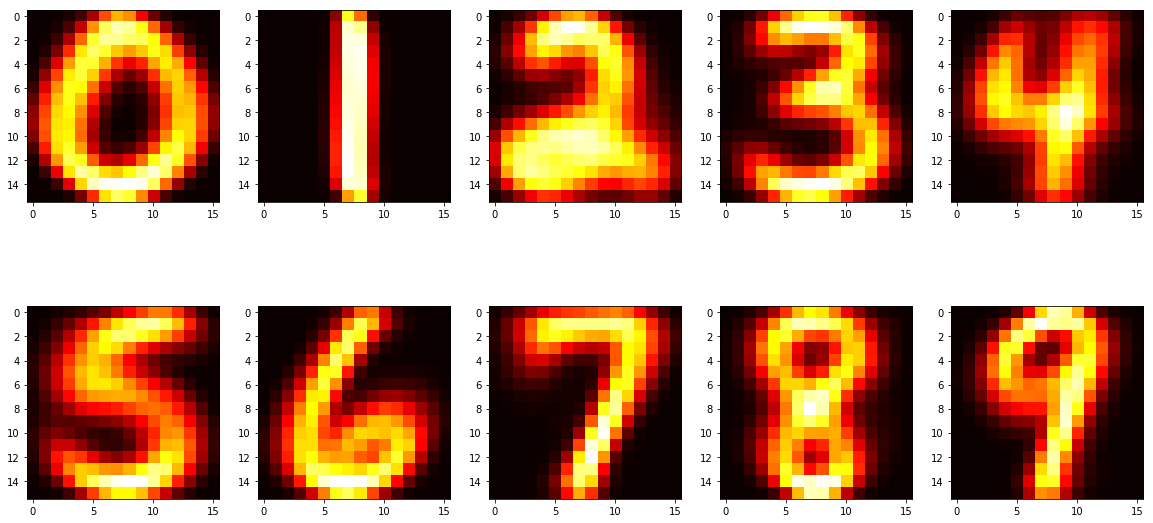

In [7]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_train_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

## Classification mit KNN

In [8]:
input_train_data = cleaned_train_data.iloc[:,1:].values
input_train_data.shape


(7291, 256)

In [9]:
# Set targets
exp_train = Experiment(cleaned_train_data[0].values,cleaned_train_data[0].values)

In [10]:
# input featurs are the individual pixels of the image - without transformation
exp_train.add_input_data('256_pixel', input_train_data)

In [11]:
exp_train.add_config(KNeighborsClassifier(n_neighbors=1), 'KNN_1', '256_pixel')

In [12]:
exp_train.get_names()

['KNN_1']

In [13]:
exp_train.get_config_map()

CONFIG: KNN_1 256_pixel 	Num features: 256


In [14]:
exp_train.fit()

Fitting  KNN_1 ... 
done in  1.815103530883789 s.


# 'Train' KNN with zip.train & calculate training error

In [15]:
exp_train.predict_all(input_train_data,train = True)

Predicting data with KNN_1 ... 
done in  51.056920289993286 s.


In [16]:
results_train = exp_train.get_results(train = True)
results_train.head()

,targets,KNN_1
0,6.0,6.0
1,5.0,5.0
2,4.0,4.0
3,7.0,7.0
4,3.0,3.0


In [17]:
#1.0*(results_train['targets'] == results_train['KNN_3']).sum()/results_train['targets'].count()

In [18]:
1.0*(results_train['targets'] == results_train['KNN_1']).sum()/results_train['targets'].count()

1.0

In [19]:
#1.0*(results_train['targets'] == results_train['KNN_20']).sum()/results_train['targets'].count()

# Validate with zip.test


In [20]:
test_data = pd.read_csv("Daten/zip.test", header=None, sep=" ") 
cleaned_test_data = test_data.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_test_data.shape
input_test_data = cleaned_test_data.iloc[:,1:].values
input_test_data.shape

(2007, 256)

In [21]:
cleaned_test_data[0].values

array([9, 6, 3, ..., 4, 0, 1], dtype=int64)

In [22]:
exp_test = Experiment(cleaned_train_data[0].values,cleaned_test_data[0].values)
# input featurs are the individual pixels of the image - without transformation
exp_test.add_input_data('256_pixel', input_train_data)
exp_test.add_config(KNeighborsClassifier(n_neighbors=1), 'KNN_1', '256_pixel')

In [23]:
for k in np.arange(1,15,2):
    dataname = 'KNN_'+str(k)
    #print(dataname)
    exp_test.add_config(KNeighborsClassifier(n_neighbors=k), dataname, '256_pixel')

In [24]:
exp_test.get_names()
exp_test.get_config_map()
exp_test.fit()
exp_test.predict_all(input_test_data)

CONFIG: KNN_1 256_pixel 	Num features: 256
CONFIG: KNN_1 256_pixel 	Num features: 256
CONFIG: KNN_3 256_pixel 	Num features: 256
CONFIG: KNN_5 256_pixel 	Num features: 256
CONFIG: KNN_7 256_pixel 	Num features: 256
CONFIG: KNN_9 256_pixel 	Num features: 256
CONFIG: KNN_11 256_pixel 	Num features: 256
CONFIG: KNN_13 256_pixel 	Num features: 256
Fitting  KNN_1 ... 
done in  2.04911732673645 s.
Fitting  KNN_1 ... 
done in  1.6460943222045898 s.
Fitting  KNN_3 ... 
done in  2.7991602420806885 s.
Fitting  KNN_5 ... 
done in  1.8001031875610352 s.
Fitting  KNN_7 ... 
done in  1.6470942497253418 s.
Fitting  KNN_9 ... 
done in  1.5950911045074463 s.
Fitting  KNN_11 ... 
done in  1.7250988483428955 s.
Fitting  KNN_13 ... 
done in  1.8271045684814453 s.
Predicting data with KNN_1 ... 
done in  26.670525312423706 s.
Predicting data with KNN_1 ... 
done in  26.753530263900757 s.
Predicting data with KNN_3 ... 
done in  28.527631998062134 s.
Predicting data with KNN_5 ... 
done in  26.0074875354766

In [1]:
results_test = exp_test.get_results()
results_test

NameError: name 'exp_test' is not defined

In [26]:
exp_test.configs

[{'name': 'KNN_1',
  'algo': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=1, p=2,
             weights='uniform'),
  'input_data_name': '256_pixel',
  'fit': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=1, p=2,
             weights='uniform')},
 {'name': 'KNN_1',
  'algo': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=1, p=2,
             weights='uniform'),
  'input_data_name': '256_pixel',
  'fit': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=1, p=2,
             weights='uniform')},
 {'name': 'KNN_3',
  'algo': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             

In [27]:
exp_test.input_data

{'256_pixel': {'description': '',
  'data': array([[-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -0.671, -0.828, -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         ...,
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])}}

# Calculate test error

In [28]:
err_rates = []
analyses_names=[]
for k in np.arange(1,15,2):
    dataname = 'KNN_'+str(k)
    analyses_names.append(dataname)
    err_rates.append(pd.Series(1.0*(results_test['targets'] == results_test[dataname]).sum()/results_test['targets'].count()))
rates_df = pd.concat(err_rates,axis = 1)
rates_df.columns = analyses_names
rates_df.index = ["accuracy_rate"]
display(rates_df)

,KNN_1,KNN_3,KNN_5,KNN_7,KNN_9,KNN_11,KNN_13
accuracy_rate,0.943697,0.944694,0.944694,0.941704,0.93722,0.931241,0.929746


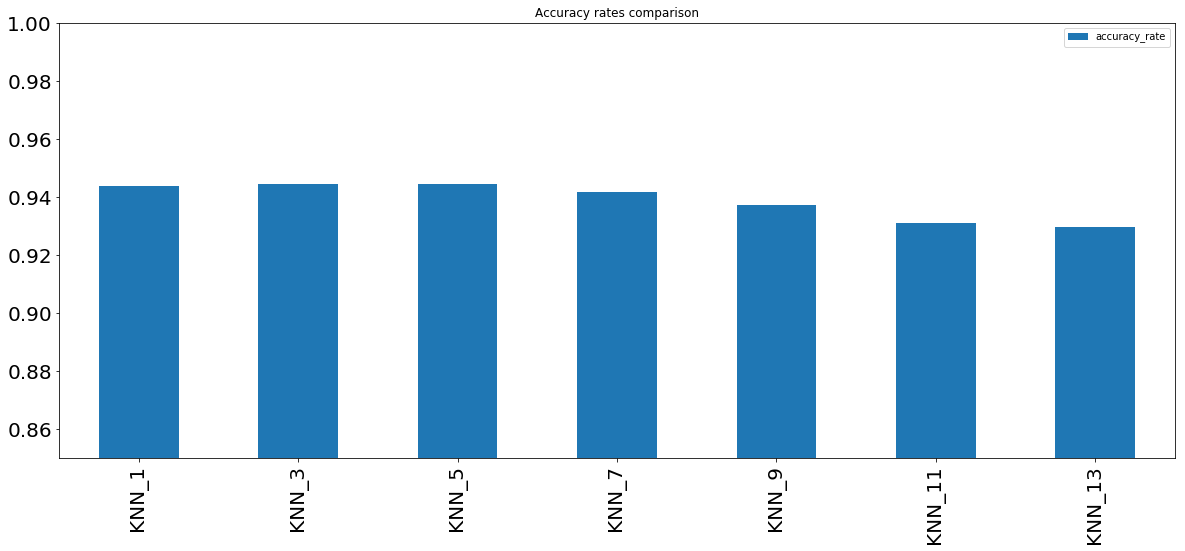

In [29]:
rates_df.T.plot(kind='bar',figsize=(20,8),rot=90,ylim=(0.85,1),title = "Accuracy rates comparison",fontsize=20)


Aufgabe 2:

- Training einer Logistischen Regression zur Klassifizierung der Digits (Evtl. mit der Klassifizierung einer Digit beginnen)

- Berechnung der Test-Fehler

- Anpassung der Inputdaten (Feature Engineering: Bildblöcke, quantisierte Grauwerte )

- ‘Negative Log Loss’ auf den Testdaten ist entscheidend